In [70]:
import numpy as np
from tqdm import tqdm
from numba import njit

from multiprocessing import Pool

In [103]:
@njit
def spherical_func(X, X0=np.array([2, 3])):
    return np.sum(np.power(X - X0, 2))


@njit
def rastrigin_func(X):
    return np.sum(np.power(X, 2) - 10*np.cos(2*np.pi*X) + 10) - 330


#@njit
def rosenbrok_func(X):
    s = 0
    for i in range(X.shape[0] - 1):
        s += 100 * (X[i]**2 - X[i+1])**2 + (X[i] - 1)**2
    return s - 390

rastrigin_func(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

-314.6413595499958

In [47]:
# Матрица попарных расстояний
@njit
def calc_dist(X):
    dist = np.zeros((X.shape[0], X.shape[0]))
    for i in range(1, X.shape[0]):
        for j in range(i):
            dist[i, j] = np.linalg.norm(X[i]-X[j])
            dist[j, i] = dist[i, j]
    return dist

# Построить NNNS для Xi
def MNNS(X, FX, i):
    dist = calc_dist(X)
    sequence = [(i, X[i], FX[i])]
    while True:
        candidates = np.argwhere(FX < sequence[-1][2])
        if len(candidates) == 0:
            break
        min_dist = dist[sequence[-1][0], candidates].min()
        h = np.argwhere(dist[sequence[-1][0]] == min_dist)[0, 0]
        sequence.append((h, X[h], FX[h]))
    return sequence


# Стратегии поиска, входящие в SP
def ss1(X, FX, i):
    MSi = np.array(np.array([j[1] for j in MNNS(X, FX, i)]))
    MCXi = np.mean(MSi, axis=0)
    best = np.argwhere(FX == np.min(FX))[0, 0]
    k = np.random.randint(X.shape[0] - 1)
    if k >= i:
        k += 1
    Vi = MCXi + np.random.uniform(-1., 1.)*(X[best] - X[k])
    return Vi

def ss2(X, FX, i):
    MSi = np.array(np.array([j[1] for j in MNNS(X, FX, i)]))
    best = np.argwhere(FX == np.min(FX))[0, 0]
    if MSi.shape[0] == 1:
        k = np.random.randint(X.shape[0] - 1)
        if k >= i:
            k += 1
        Vi = X[best] + np.random.uniform(-1., 1.)*(X[best] - X[k])
    else:
        h = np.random.randint(MSi.shape[0] - 1)
        Vi = X[best] + np.random.uniform(-1., 1.)*(X[h+1] - X[h])
    return Vi

In [128]:
def initialize_X(SN, Xmin, Xmax, SP, func):
    if Xmin.shape != Xmax.shape:
        raise ValueError('initialize_X: Xmin.shape != Xmax.shape')
    X = np.zeros((SN, Xmin.shape[0]))
    FX = np.zeros(SN)
    for i in range(SN):
        X[i] = Xmin + np.random.uniform(0, 1, Xmin.shape[0])*(Xmax - Xmin)
        FX[i] = func(X[i])
    SP_idx = np.random.randint(len(SP), size=X.shape[0])
    return X, FX, SP_idx


def employed_phase(X, FX, SP, SP_idx, trial, func):
    V = np.zeros(X.shape)
    FV = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        V[i] = SP[SP_idx[i]](X, FX, i)
        FV[i] = func(V[i])
    for i in range(X.shape[0]):
        if FV[i] < FX[i]:
            X[i] = V[i]
            FX[i] = FV[i]
            trial[i] = 0
            # Обновляем стратегию поиска
            SP_idx_candidate = np.random.randint(len(SP) - 1)
            if SP_idx_candidate == SP_idx[i]:
                SP_idx[i] = SP_idx_candidate + 1
            else:
                SP_idx[i] = SP_idx_candidate
        else:
            trial[i] += 1
    return X, FX, SP_idx, trial


def onlooker_phase(X, FX, SP, SP_idx, trial, func):
    V = np.zeros(X.shape)
    FV = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        MSi = np.array(np.array([j[1] for j in MNNS(X, FX, i)]))
        r = np.random.randint(MSi.shape[0]-1) + 1 if MSi.shape[0] > 1 else 0
        h = np.argwhere(FX == func(MSi[r]))[0, 0]
        V[h] = SP[SP_idx[h]](X, FX, h)
        FV[h] = func(V[h])
    for i in range(X.shape[0]):
        if FV[i] == 0:
            continue
        if FV[i] < FX[i]:
            X[i] = V[i]
            FX[i] = FV[i]
            trial[i] = 0
            # Обновляем стратегию поиска
            SP_idx_candidate = np.random.randint(len(SP) - 1)
            if SP_idx_candidate == SP_idx[i]:
                SP_idx[i] = SP_idx_candidate + 1
            else:
                SP_idx[i] = SP_idx_candidate
        else:
            trial[i] += 1
    return X, FX, SP_idx, trial

def onlooker_old_phase(X, FX, SP, SP_idx, trial, func):
    def fit(f):
        return 1./(1+f) if f >= 0 else 1 + np.abs(f)
    
    fitX = np.vectorize(fit)(FX)
    idx_selected = np.random.choice(
        X.shape[0],
        p=fitX/np.sum(fitX)
    )
    X_selected = X[idx_selected].copy()
    
    V = np.zeros(X.shape)
    FV = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        k = np.random.randint(X.shape[0] - 1)
        if k >= i:
            k += 1
        V[i] = X[i] + np.random.uniform(-1., 1.)*(X[i] - X_selected)
        FV[i] = func(V[i])
    for i in range(X.shape[0]):
        if FV[i] < FX[i]:
            X[i] = V[i]
            FX[i] = FV[i]
            trial[i] = 0
        else:
            trial[i] += 1            
    return X, FX, SP_idx, trial


def scout_phase(X, FX, SP, SP_idx, trial, func, Xmin, Xmax, trial_lim):
    for i in range(X.shape[0]):
        if trial[i] >= trial_lim:
            XX, FXX, SP_idxXX = initialize_X(1, Xmin, Xmax, SP, func)
            X[i] = XX[0]
            FX[i] = FXX[0]
            SP_idx[i] = SP_idxXX[0]
            trial[i] = 0
    return X, FX, SP_idx, trial


def form_data(iteration, phase, X, FX, SP_idx, trial):
    return {
        'iteration': 0,
        'phase': 'initialize',
        'X': X.copy(),
        'FX': FX.copy(),
        'SP_idx': SP_idx.copy(),
        'trial': trial.copy()
    }

def NNSABC(SN, Xmin, Xmax, SP, func, max_iterations=1000, trial_lim=20, stagnation_lim=20, stagnation_eps=1e-6):
    path = []
    stagnation_cnt = 0
    stop_reason = 'max_iterations'
    X, FX, SP_idx = initialize_X(SN, Xmin, Xmax, SP, func)
    trial = np.zeros(X.shape[0])
    path.append(form_data(0, 'initialize', X, FX, SP_idx, trial))
    X_best_prev = X[np.argwhere(FX == np.min(FX))[0, 0]]
    for iteration in tqdm(range(max_iterations)):
        X_best_curr = X[np.argwhere(FX == np.min(FX))[0, 0]]
        if np.abs(func(X_best_curr) - func(X_best_prev)) < stagnation_eps:
            stagnation_cnt += 1
            if stagnation_cnt >= stagnation_lim:
                stop_reason = 'stagnation_lim'
                break
        else:
            stagnation_cnt = 0
        X_best_prev = X_best_curr
        X, FX, SP_idx, trial = employed_phase(X, FX, SP, SP_idx, trial, func)
        path.append(form_data(iteration, 'employed', X, FX, SP_idx, trial))
        #X, FX, SP_idx, trial = onlooker_phase(X, FX, SP, SP_idx, trial, func)
        X, FX, SP_idx, trial = onlooker_old_phase(X, FX, SP, SP_idx, trial, func)
        path.append(form_data(iteration, 'onlooker', X, FX, SP_idx, trial))
        X, FX, SP_idx, trial = scout_phase(X, FX, SP, SP_idx, trial, func, Xmin, Xmax, trial_lim=10)
    return stop_reason, X_best_curr, X, FX, path

func = rastrigin_func
#func = rosenbrok_func

dimensions = 2
alpha = 5
#alpha = 100
Xmin = np.array([- alpha] * dimensions)
Xmax = np.array([alpha] * dimensions)
SN = 50
SP = [ss1, ss2]
max_iterations = 200

stop_reason, X_best,  X,FX, path = NNSABC(SN, Xmin, Xmax, SP, func, max_iterations)
FX_best = func(X_best)
print(stop_reason)
print(FX_best)
print(X_best)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:15<00:00, 12.60it/s]

max_iterations
-329.99999999999983
[2.48274874e-08 1.10993406e-08]


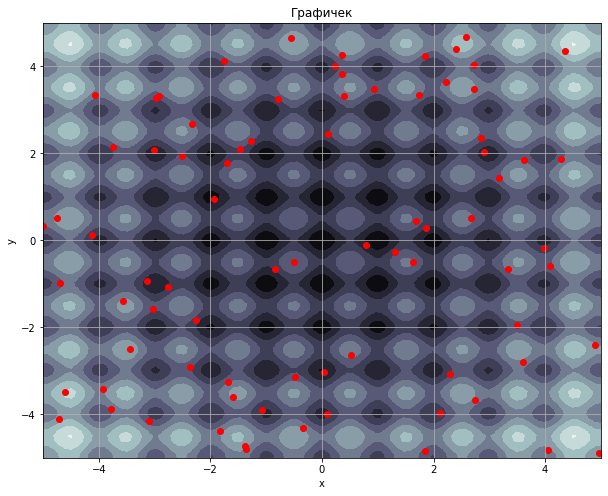

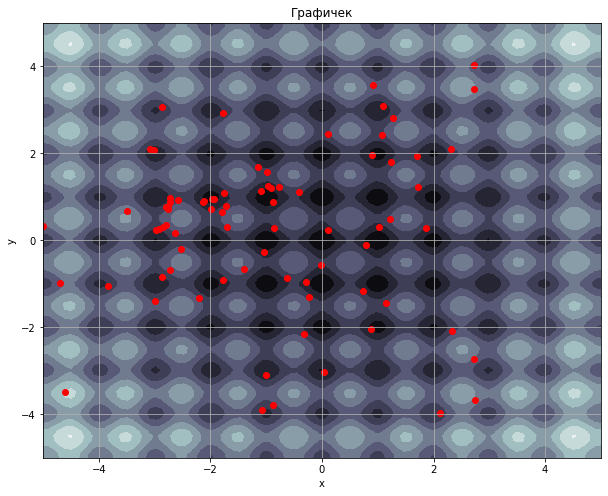

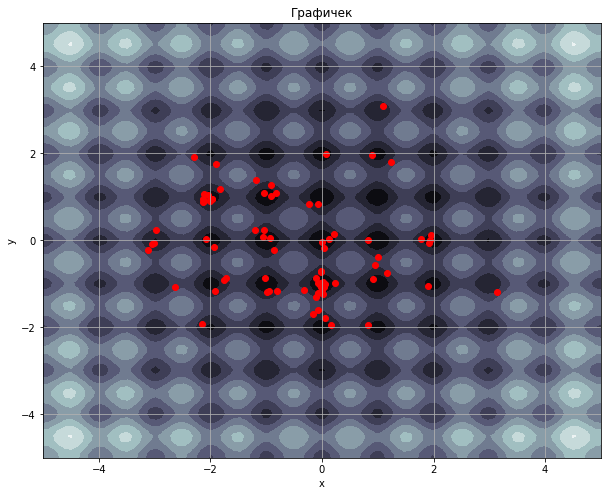

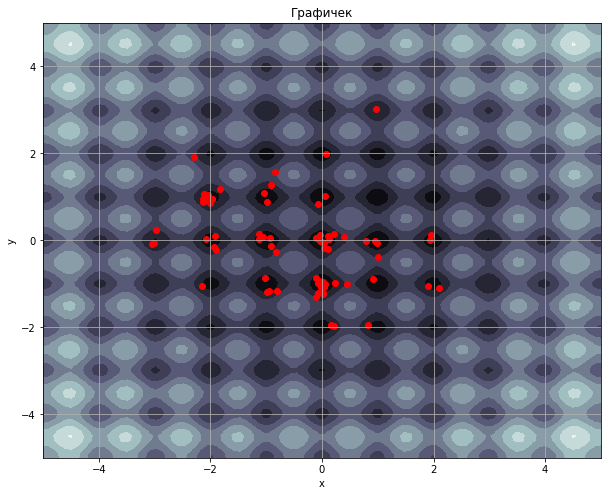

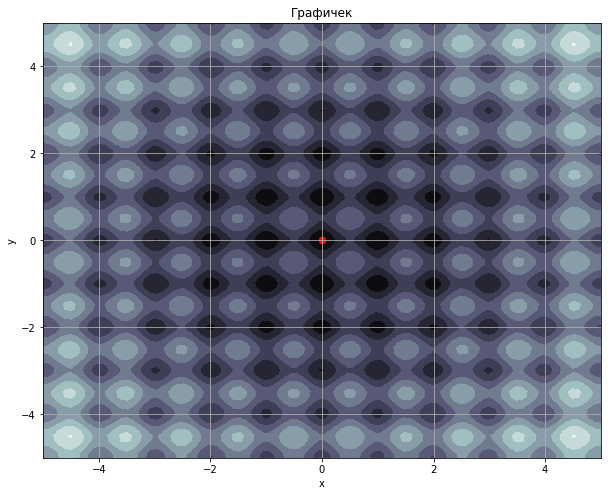

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_X(X, Xmin, Xmax, func=None):
    if X.shape[1] != 2:
        return
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_xlim([Xmin[0], Xmax[0]])
    ax1.set_ylim([Xmin[1], Xmax[1]])
    if func:
        size = 100
        XX, YY = np.meshgrid(np.linspace(Xmin[0], Xmax[0], size), np.linspace(Xmin[1], Xmax[1], size))
        Z = np.zeros((size, size))
        for i, x in enumerate(np.linspace(Xmin[0], Xmax[0], size)):
            for j, y in enumerate(np.linspace(Xmin[1], Xmax[1], size)):
                Z[j, i] = func(np.array([x, y]))
        ax1.contourf(XX, YY, Z, cmap=plt.cm.bone)
    ax1.scatter(X[:, 0], X[:, 1], c='red')
    plt.title('Графичек')
    plt.grid()
    #plt.legend(loc='upper left')
    plt.show()
    
plot_X(path[0]['X'], Xmin, Xmax, func)
plot_X(path[2]['X'], Xmin, Xmax, func)
plot_X(path[8]['X'], Xmin, Xmax, func)
plot_X(path[10]['X'], Xmin, Xmax, func)
plot_X(path[-1]['X'], Xmin, Xmax, func)

In [131]:
# Тестируем Растригина

dimensions_list = [2, 4, 8, 16, 32]

func = rastrigin_func
alpha = 5
SN = 80
SP = [ss1, ss2]
max_iterations = 1000

res = []

for dimensions in dimensions_list:
    Xmin = np.array([- alpha] * dimensions)
    Xmax = np.array([alpha] * dimensions)
    for start in range(100):
        print('dimensions:', dimensions)
        print('start num: ', start)
        print('Xmin:      ')
        print(Xmin)
        print('Xmax:      ')
        print(Xmax)
        stop_reason, X_best,  X,FX, path = NNSABC(SN, Xmin, Xmax, SP, func, max_iterations)
        FX_best = func(X_best)
        print('stop_reason', stop_reason)
        print('FX_best', FX_best)
        res.append({
            'start_num': start,
            'stop_reason': stop_reason,
            'FX_best': FX_best,
            'X_best': X_best,
            'path': path
        })

dimensions: 2
start num:  0
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  3%|██▋                                                                             | 34/1000 [00:02<01:17, 12.51it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  1
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 23%|██████████████████▏                                                            | 230/1000 [00:18<01:00, 12.67it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  2
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [00:51<00:27, 12.69it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  3
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 16%|████████████▉                                                                  | 164/1000 [00:13<01:06, 12.56it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  4
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 16%|████████████▌                                                                  | 159/1000 [00:12<01:06, 12.60it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  5
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|█████                                                                           | 63/1000 [00:05<01:14, 12.59it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  6
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 34%|██████████████████████████▉                                                    | 341/1000 [00:26<00:52, 12.63it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  7
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 17%|█████████████▋                                                                 | 173/1000 [00:13<01:05, 12.60it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  8
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [01:08<00:09, 12.69it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  9
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [01:06<00:12, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  10
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 32%|█████████████████████████▌                                                     | 323/1000 [00:25<00:53, 12.64it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  11
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|██▉                                                                             | 37/1000 [00:02<01:16, 12.53it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  12
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|██▊                                                                             | 35/1000 [00:02<01:17, 12.51it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  13
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 15%|███████████▉                                                                   | 151/1000 [00:11<01:07, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  14
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 43%|██████████████████████████████████▎                                            | 434/1000 [00:34<00:44, 12.71it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  15
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 15%|████████████                                                                   | 152/1000 [00:12<01:07, 12.62it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  16
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▉                                                                           | 62/1000 [00:04<01:14, 12.54it/s]


stop_reason stagnation_lim
FX_best -329.0050409429067
dimensions: 2
start num:  17
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 21%|████████████████▌                                                              | 209/1000 [00:16<01:02, 12.62it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  18
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 26%|████████████████████▏                                                          | 255/1000 [00:20<00:59, 12.62it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  19
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▉                                                                           | 62/1000 [00:04<01:14, 12.56it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  20
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 23%|█████████████████▉                                                             | 227/1000 [00:17<01:00, 12.72it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  21
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 10%|███████▊                                                                        | 98/1000 [00:07<01:11, 12.66it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  22
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 49%|██████████████████████████████████████▍                                        | 486/1000 [00:38<00:40, 12.67it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  23
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 24%|██████████████████▋                                                            | 236/1000 [00:18<01:00, 12.68it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  24
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 24%|██████████████████▋                                                            | 237/1000 [00:18<01:00, 12.62it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  25
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 12%|█████████▋                                                                     | 122/1000 [00:09<01:09, 12.56it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  26
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|███████▍                                                                        | 93/1000 [00:07<01:11, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  27
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 31%|████████████████████████▋                                                      | 313/1000 [00:24<00:54, 12.69it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  28
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 18%|██████████████▎                                                                | 181/1000 [00:14<01:04, 12.69it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  29
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  7%|█████▌                                                                          | 70/1000 [00:05<01:13, 12.66it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  30
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 14%|███████████▍                                                                   | 144/1000 [00:11<01:07, 12.66it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  31
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 20%|████████████████                                                               | 204/1000 [00:16<01:02, 12.64it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  32
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  3%|██▍                                                                             | 31/1000 [00:02<01:16, 12.59it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  33
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|███████▌                                                                        | 94/1000 [00:07<01:11, 12.63it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  34
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 47%|█████████████████████████████████████▎                                         | 473/1000 [00:37<00:41, 12.68it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  35
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 22%|█████████████████▌                                                             | 223/1000 [00:17<01:01, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  36
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|███████                                                                         | 88/1000 [00:06<01:12, 12.62it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  37
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|███████▎                                                                        | 91/1000 [00:07<01:11, 12.71it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  38
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▊                                                                           | 60/1000 [00:04<01:15, 12.48it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  39
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 26%|████████████████████▎                                                          | 257/1000 [00:20<01:00, 12.33it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  40
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▊                                                                           | 60/1000 [00:04<01:14, 12.57it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  41
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 33%|██████████████████████████▎                                                    | 333/1000 [00:26<00:52, 12.64it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  42
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 12%|█████████▎                                                                     | 118/1000 [00:09<01:09, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  43
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 13%|██████████▎                                                                    | 130/1000 [00:10<01:08, 12.73it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  44
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 25%|███████████████████▉                                                           | 253/1000 [00:20<00:59, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  45
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 20%|███████████████▊                                                               | 200/1000 [00:15<01:03, 12.61it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  46
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|██▉                                                                             | 37/1000 [00:02<01:16, 12.59it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  47
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 23%|██████████████████▍                                                            | 233/1000 [00:18<01:01, 12.43it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  48
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 40%|███████████████████████████████▊                                               | 402/1000 [00:31<00:47, 12.61it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  49
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 33%|██████████████████████████▎                                                    | 333/1000 [00:26<00:52, 12.67it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  50
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 22%|████████████████▉                                                              | 215/1000 [00:16<01:01, 12.69it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  51
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 16%|████████████▊                                                                  | 162/1000 [00:12<01:05, 12.70it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  52
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 39%|██████████████████████████████▊                                                | 390/1000 [00:30<00:48, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  53
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|███████▏                                                                        | 90/1000 [00:07<01:13, 12.46it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  54
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 13%|██████████▎                                                                    | 131/1000 [00:10<01:08, 12.61it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  55
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 28%|█████████████████████▉                                                         | 277/1000 [00:21<00:57, 12.64it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  56
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|█████▏                                                                          | 65/1000 [00:05<01:13, 12.70it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  57
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 34%|███████████████████████████▎                                                   | 345/1000 [00:27<00:51, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  58
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|███▎                                                                            | 42/1000 [00:03<01:16, 12.56it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  59
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▋                                                                           | 58/1000 [00:04<01:14, 12.69it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  60
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 12%|█████████▍                                                                     | 120/1000 [00:09<01:09, 12.63it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  61
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 35%|███████████████████████████▉                                                   | 354/1000 [00:27<00:51, 12.66it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  62
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 26%|████████████████████▎                                                          | 257/1000 [00:20<00:58, 12.68it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  63
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 12%|█████████▏                                                                     | 116/1000 [00:09<01:09, 12.64it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  64
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 60%|███████████████████████████████████████████████▋                               | 604/1000 [00:47<00:31, 12.67it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  65
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [01:10<00:09, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  66
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|███████▎                                                                        | 91/1000 [00:07<01:11, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  67
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 59%|██████████████████████████████████████████████▎                                | 586/1000 [00:46<00:32, 12.66it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  68
Xmin:      
[-5 -5]
Xmax:      
[5 5]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.65it/s]


stop_reason max_iterations
FX_best -329.99999999984874
dimensions: 2
start num:  69
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 26%|████████████████████▊                                                          | 264/1000 [00:20<00:58, 12.65it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  70
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 14%|███████████▎                                                                   | 143/1000 [00:11<01:07, 12.66it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  71
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [00:58<00:22, 12.31it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  72
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 29%|██████████████████████▊                                                        | 289/1000 [00:34<01:24,  8.46it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  73
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 10%|███████▌                                                                        | 95/1000 [00:11<01:47,  8.41it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  74
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  9%|██████▉                                                                         | 86/1000 [00:10<01:47,  8.52it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  75
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 34%|███████████████████████████▏                                                   | 344/1000 [00:41<01:19,  8.28it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  76
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 22%|█████████████████▏                                                             | 218/1000 [00:26<01:36,  8.13it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  77
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 28%|█████████████████████▋                                                         | 275/1000 [00:33<01:29,  8.13it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  78
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 17%|█████████████                                                                  | 166/1000 [00:20<01:42,  8.18it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  79
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|███                                                                             | 39/1000 [00:04<01:56,  8.23it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  80
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 15%|████████████                                                                   | 152/1000 [00:18<01:44,  8.14it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  81
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 42%|█████████████████████████████████▎                                             | 421/1000 [00:38<00:52, 11.06it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  82
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [00:56<00:33, 11.09it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  83
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 30%|███████████████████████▍                                                       | 297/1000 [00:37<01:27,  8.02it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  84
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▌                                                                           | 57/1000 [00:06<01:41,  9.31it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  85
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  6%|████▌                                                                           | 57/1000 [00:05<01:29, 10.54it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  86
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|███▏                                                                            | 40/1000 [00:03<01:20, 11.89it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  87
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 14%|██████████▋                                                                    | 135/1000 [00:13<01:26, 10.03it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  88
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  3%|██▋                                                                             | 33/1000 [00:04<01:57,  8.24it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  89
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 53%|█████████████████████████████████████████▉                                     | 531/1000 [01:04<00:56,  8.23it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  90
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [01:02<00:45,  9.27it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  91
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [01:40<00:21,  8.22it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  92
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 12%|█████████▎                                                                     | 118/1000 [00:14<01:46,  8.26it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  93
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  4%|██▊                                                                             | 35/1000 [00:04<02:00,  7.98it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  94
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 20%|███████████████▍                                                               | 195/1000 [00:18<01:18, 10.30it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  95
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 17%|█████████████▌                                                                 | 172/1000 [00:15<01:15, 10.92it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  96
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 23%|██████████████████▍                                                            | 234/1000 [00:29<01:36,  7.93it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  97
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 50%|███████████████████████████████████████▋                                       | 503/1000 [01:03<01:02,  7.90it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 2
start num:  98
Xmin:      
[-5 -5]
Xmax:      
[5 5]


  3%|██▍                                                                             | 31/1000 [00:04<02:05,  7.72it/s]


stop_reason stagnation_lim
FX_best -329.0050409429067
dimensions: 2
start num:  99
Xmin:      
[-5 -5]
Xmax:      
[5 5]


 53%|█████████████████████████████████████████▌                                     | 526/1000 [00:51<00:46, 10.21it/s]


stop_reason stagnation_lim
FX_best -330.0
dimensions: 4
start num:  0
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 42/1000 [00:03<01:20, 11.94it/s]


stop_reason stagnation_lim
FX_best -324.0302505345598
dimensions: 4
start num:  1
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 42/1000 [00:03<01:20, 11.91it/s]


stop_reason stagnation_lim
FX_best -327.0151228287194
dimensions: 4
start num:  2
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 42/1000 [00:03<01:19, 11.98it/s]


stop_reason stagnation_lim
FX_best -328.0100818856451
dimensions: 4
start num:  3
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 42/1000 [00:03<01:17, 12.33it/s]


stop_reason stagnation_lim
FX_best -325.02520975235217
dimensions: 4
start num:  4
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:04<01:20, 11.88it/s]


stop_reason stagnation_lim
FX_best -324.0302506908055
dimensions: 4
start num:  5
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:04<01:19, 11.97it/s]


stop_reason stagnation_lim
FX_best -326.01998903066686
dimensions: 4
start num:  6
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▊                                                                            | 47/1000 [00:03<01:18, 12.18it/s]


stop_reason stagnation_lim
FX_best -327.0151228287172
dimensions: 4
start num:  7
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:06<01:17, 11.82it/s]


stop_reason stagnation_lim
FX_best -324.9870831938594
dimensions: 4
start num:  8
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▌                                                                           | 57/1000 [00:04<01:18, 11.98it/s]


stop_reason stagnation_lim
FX_best -329.99740406400156
dimensions: 4
start num:  9
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▋                                                                            | 46/1000 [00:03<01:20, 11.88it/s]


stop_reason stagnation_lim
FX_best -325.02517196138217
dimensions: 4
start num:  10
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 41/1000 [00:03<01:20, 11.97it/s]


stop_reason stagnation_lim
FX_best -328.01008188153145
dimensions: 4
start num:  11
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▊                                                                           | 60/1000 [00:05<01:19, 11.88it/s]


stop_reason stagnation_lim
FX_best -324.03013524910403
dimensions: 4
start num:  12
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:19, 11.75it/s]


stop_reason stagnation_lim
FX_best -328.0100309015832
dimensions: 4
start num:  13
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 45/1000 [00:03<01:19, 12.04it/s]


stop_reason stagnation_lim
FX_best -329.0050409405811
dimensions: 4
start num:  14
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 11%|████████▌                                                                      | 108/1000 [00:09<01:16, 11.67it/s]


stop_reason stagnation_lim
FX_best -329.00477734722955
dimensions: 4
start num:  15
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▏                                                                            | 40/1000 [00:03<01:21, 11.83it/s]


stop_reason stagnation_lim
FX_best -329.0050408755595
dimensions: 4
start num:  16
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▊                                                                            | 47/1000 [00:03<01:20, 11.90it/s]


stop_reason stagnation_lim
FX_best -327.01512277552007
dimensions: 4
start num:  17
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 45/1000 [00:03<01:18, 12.22it/s]


stop_reason stagnation_lim
FX_best -328.0100818857846
dimensions: 4
start num:  18
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:04<01:19, 11.99it/s]


stop_reason stagnation_lim
FX_best -329.0050409428455
dimensions: 4
start num:  19
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|████                                                                            | 50/1000 [00:04<01:20, 11.85it/s]


stop_reason stagnation_lim
FX_best -328.01008188022837
dimensions: 4
start num:  20
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  8%|██████▏                                                                         | 78/1000 [00:06<01:15, 12.15it/s]


stop_reason stagnation_lim
FX_best -325.02520975232864
dimensions: 4
start num:  21
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:18, 11.89it/s]


stop_reason stagnation_lim
FX_best -324.03018762018405
dimensions: 4
start num:  22
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▊                                                                            | 48/1000 [00:03<01:18, 12.06it/s]


stop_reason stagnation_lim
FX_best -329.0050409360734
dimensions: 4
start num:  23
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███                                                                             | 38/1000 [00:03<01:19, 12.07it/s]


stop_reason stagnation_lim
FX_best -328.01008185022783
dimensions: 4
start num:  24
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|██▉                                                                             | 36/1000 [00:02<01:19, 12.13it/s]


stop_reason stagnation_lim
FX_best -329.00504094289784
dimensions: 4
start num:  25
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▊                                                                           | 60/1000 [00:05<01:18, 11.94it/s]


stop_reason stagnation_lim
FX_best -327.01380976260197
dimensions: 4
start num:  26
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▋                                                                          | 71/1000 [00:05<01:17, 11.94it/s]


stop_reason stagnation_lim
FX_best -329.0047125171738
dimensions: 4
start num:  27
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|█████▏                                                                          | 65/1000 [00:05<01:18, 11.92it/s]


stop_reason stagnation_lim
FX_best -328.0100438078244
dimensions: 4
start num:  28
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▊                                                                           | 60/1000 [00:05<01:18, 11.95it/s]


stop_reason stagnation_lim
FX_best -328.01004779269243
dimensions: 4
start num:  29
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▊                                                                          | 72/1000 [00:06<01:19, 11.67it/s]


stop_reason stagnation_lim
FX_best -329.0050300775868
dimensions: 4
start num:  30
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|████                                                                            | 51/1000 [00:04<01:18, 12.15it/s]


stop_reason stagnation_lim
FX_best -327.0151226020795
dimensions: 4
start num:  31
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 42/1000 [00:03<01:18, 12.21it/s]


stop_reason stagnation_lim
FX_best -326.0201637709829
dimensions: 4
start num:  32
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▉                                                                          | 74/1000 [00:06<01:17, 11.92it/s]


stop_reason stagnation_lim
FX_best -328.0100517857793
dimensions: 4
start num:  33
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:18, 11.84it/s]


stop_reason stagnation_lim
FX_best -329.00503048279637
dimensions: 4
start num:  34
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|██▉                                                                             | 37/1000 [00:03<01:19, 12.04it/s]


stop_reason stagnation_lim
FX_best -326.0201637580231
dimensions: 4
start num:  35
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▍                                                                           | 56/1000 [00:04<01:19, 11.91it/s]


stop_reason stagnation_lim
FX_best -327.01512280968853
dimensions: 4
start num:  36
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▉                                                                           | 61/1000 [00:05<01:19, 11.88it/s]


stop_reason stagnation_lim
FX_best -324.0299233284129
dimensions: 4
start num:  37
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|████                                                                            | 50/1000 [00:04<01:16, 12.38it/s]


stop_reason stagnation_lim
FX_best -326.0201637716268
dimensions: 4
start num:  38
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▋                                                                            | 46/1000 [00:03<01:17, 12.29it/s]


stop_reason stagnation_lim
FX_best -327.0151228287199
dimensions: 4
start num:  39
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▋                                                                           | 59/1000 [00:04<01:18, 12.05it/s]


stop_reason stagnation_lim
FX_best -327.01150468342877
dimensions: 4
start num:  40
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|█████                                                                           | 64/1000 [00:05<01:17, 12.08it/s]


stop_reason stagnation_lim
FX_best -327.0142980177125
dimensions: 4
start num:  41
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|████▏                                                                           | 52/1000 [00:04<01:18, 12.10it/s]


stop_reason stagnation_lim
FX_best -329.999999032329
dimensions: 4
start num:  42
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▌                                                                          | 70/1000 [00:05<01:17, 12.04it/s]


stop_reason stagnation_lim
FX_best -327.99996042013333
dimensions: 4
start num:  43
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|█████▏                                                                          | 65/1000 [00:05<01:18, 11.98it/s]


stop_reason stagnation_lim
FX_best -327.01477526076206
dimensions: 4
start num:  44
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▊                                                                           | 60/1000 [00:05<01:19, 11.84it/s]


stop_reason stagnation_lim
FX_best -328.0096591286736
dimensions: 4
start num:  45
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▋                                                                          | 71/1000 [00:05<01:17, 11.94it/s]


stop_reason stagnation_lim
FX_best -328.0100818359131
dimensions: 4
start num:  46
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 44/1000 [00:03<01:19, 12.05it/s]


stop_reason stagnation_lim
FX_best -329.00504002408707
dimensions: 4
start num:  47
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▊                                                                          | 73/1000 [00:06<01:17, 12.04it/s]


stop_reason stagnation_lim
FX_best -329.9510556887334
dimensions: 4
start num:  48
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  9%|███████▏                                                                        | 90/1000 [00:07<01:15, 12.03it/s]


stop_reason stagnation_lim
FX_best -326.01835842789114
dimensions: 4
start num:  49
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  9%|██████▉                                                                         | 87/1000 [00:07<01:16, 11.94it/s]


stop_reason stagnation_lim
FX_best -328.00389358601245
dimensions: 4
start num:  50
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███                                                                             | 39/1000 [00:03<01:19, 12.16it/s]


stop_reason stagnation_lim
FX_best -327.0151228268047
dimensions: 4
start num:  51
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 44/1000 [00:03<01:19, 12.09it/s]


stop_reason stagnation_lim
FX_best -328.01008179341375
dimensions: 4
start num:  52
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 11%|████████▌                                                                      | 108/1000 [00:09<01:14, 11.94it/s]


stop_reason stagnation_lim
FX_best -325.9873158136027
dimensions: 4
start num:  53
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 13%|██████████                                                                     | 128/1000 [00:10<01:14, 11.73it/s]


stop_reason stagnation_lim
FX_best -325.02313403308517
dimensions: 4
start num:  54
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▊                                                                           | 60/1000 [00:05<01:18, 11.99it/s]


stop_reason stagnation_lim
FX_best -328.01007917067795
dimensions: 4
start num:  55
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 44/1000 [00:03<01:19, 12.00it/s]


stop_reason stagnation_lim
FX_best -324.03025065539975
dimensions: 4
start num:  56
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:04<01:18, 12.06it/s]


stop_reason stagnation_lim
FX_best -324.0302506946836
dimensions: 4
start num:  57
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▏                                                                            | 40/1000 [00:03<01:18, 12.30it/s]


stop_reason stagnation_lim
FX_best -323.03529163816546
dimensions: 4
start num:  58
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▊                                                                            | 48/1000 [00:03<01:18, 12.07it/s]


stop_reason stagnation_lim
FX_best -328.0100801570463
dimensions: 4
start num:  59
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 14%|██████████▉                                                                    | 138/1000 [00:11<01:11, 12.04it/s]


stop_reason stagnation_lim
FX_best -327.09830912148954
dimensions: 4
start num:  60
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 41/1000 [00:03<01:19, 12.07it/s]


stop_reason stagnation_lim
FX_best -326.02016330891075
dimensions: 4
start num:  61
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▋                                                                           | 59/1000 [00:06<01:44,  9.04it/s]


stop_reason stagnation_lim
FX_best -328.01007424667523
dimensions: 4
start num:  62
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 12%|█████████▍                                                                     | 119/1000 [00:15<01:52,  7.84it/s]


stop_reason stagnation_lim
FX_best -325.02506064142636
dimensions: 4
start num:  63
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▊                                                                           | 60/1000 [00:07<02:03,  7.60it/s]


stop_reason stagnation_lim
FX_best -326.02013147616447
dimensions: 4
start num:  64
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 10%|███████▋                                                                        | 96/1000 [00:12<01:56,  7.73it/s]


stop_reason stagnation_lim
FX_best -329.99931704023874
dimensions: 4
start num:  65
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:06<02:02,  7.77it/s]


stop_reason stagnation_lim
FX_best -326.02010887462586
dimensions: 4
start num:  66
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 44/1000 [00:05<02:04,  7.68it/s]


stop_reason stagnation_lim
FX_best -327.01512279984826
dimensions: 4
start num:  67
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 41/1000 [00:05<02:06,  7.56it/s]


stop_reason stagnation_lim
FX_best -322.0403375972185
dimensions: 4
start num:  68
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███                                                                             | 39/1000 [00:05<02:06,  7.59it/s]


stop_reason stagnation_lim
FX_best -329.00504093059504
dimensions: 4
start num:  69
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 10%|███████▊                                                                        | 97/1000 [00:12<01:59,  7.56it/s]


stop_reason stagnation_lim
FX_best -323.94528277893056
dimensions: 4
start num:  70
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 10%|███████▌                                                                        | 95/1000 [00:12<02:00,  7.51it/s]


stop_reason stagnation_lim
FX_best -327.0022885839981
dimensions: 4
start num:  71
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 10%|████████                                                                       | 102/1000 [00:12<01:52,  7.95it/s]


stop_reason stagnation_lim
FX_best -329.0049893275305
dimensions: 4
start num:  72
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  8%|██████▏                                                                         | 77/1000 [00:09<01:53,  8.11it/s]


stop_reason stagnation_lim
FX_best -328.0098855902098
dimensions: 4
start num:  73
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▍                                                                           | 55/1000 [00:06<01:56,  8.08it/s]


stop_reason stagnation_lim
FX_best -325.0251636588882
dimensions: 4
start num:  74
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▋                                                                           | 59/1000 [00:07<01:54,  8.22it/s]


stop_reason stagnation_lim
FX_best -327.01497146474674
dimensions: 4
start num:  75
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 41/1000 [00:05<01:58,  8.07it/s]


stop_reason stagnation_lim
FX_best -324.0302506952555
dimensions: 4
start num:  76
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▋                                                                           | 58/1000 [00:06<01:52,  8.36it/s]


stop_reason stagnation_lim
FX_best -327.0151213915897
dimensions: 4
start num:  77
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███                                                                             | 39/1000 [00:04<01:57,  8.18it/s]


stop_reason stagnation_lim
FX_best -321.0453785606313
dimensions: 4
start num:  78
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▏                                                                            | 40/1000 [00:04<01:57,  8.16it/s]


stop_reason stagnation_lim
FX_best -323.0352916381506
dimensions: 4
start num:  79
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▉                                                                           | 61/1000 [00:07<01:54,  8.17it/s]


stop_reason stagnation_lim
FX_best -327.0150996921085
dimensions: 4
start num:  80
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 14%|██████████▉                                                                    | 139/1000 [00:17<01:46,  8.10it/s]


stop_reason stagnation_lim
FX_best -327.0066663612528
dimensions: 4
start num:  81
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:05<01:56,  8.18it/s]


stop_reason stagnation_lim
FX_best -328.01007791742245
dimensions: 4
start num:  82
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|██▉                                                                             | 36/1000 [00:04<01:53,  8.49it/s]


stop_reason stagnation_lim
FX_best -327.01512282871965
dimensions: 4
start num:  83
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 42/1000 [00:05<01:54,  8.38it/s]


stop_reason stagnation_lim
FX_best -328.0100818856832
dimensions: 4
start num:  84
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 41/1000 [00:04<01:53,  8.44it/s]


stop_reason stagnation_lim
FX_best -326.0201637716268
dimensions: 4
start num:  85
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███                                                                             | 39/1000 [00:04<01:53,  8.43it/s]


stop_reason stagnation_lim
FX_best -329.00504094278415
dimensions: 4
start num:  86
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 21%|████████████████▌                                                              | 210/1000 [00:26<01:37,  8.06it/s]


stop_reason stagnation_lim
FX_best -324.89045960106563
dimensions: 4
start num:  87
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 10%|███████▉                                                                       | 101/1000 [00:12<01:51,  8.05it/s]


stop_reason stagnation_lim
FX_best -327.01491865297504
dimensions: 4
start num:  88
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▋                                                                            | 46/1000 [00:05<01:56,  8.16it/s]


stop_reason stagnation_lim
FX_best -321.04537393522077
dimensions: 4
start num:  89
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|████                                                                            | 50/1000 [00:06<01:54,  8.32it/s]


stop_reason stagnation_lim
FX_best -326.02016376523466
dimensions: 4
start num:  90
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  5%|███▉                                                                            | 49/1000 [00:05<01:52,  8.45it/s]


stop_reason stagnation_lim
FX_best -328.0100751891009
dimensions: 4
start num:  91
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|█████                                                                           | 64/1000 [00:07<01:55,  8.14it/s]


stop_reason stagnation_lim
FX_best -328.0100651349739
dimensions: 4
start num:  92
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▎                                                                          | 66/1000 [00:08<01:54,  8.19it/s]


stop_reason stagnation_lim
FX_best -329.0047937538092
dimensions: 4
start num:  93
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▉                                                                           | 61/1000 [00:07<01:54,  8.17it/s]


stop_reason stagnation_lim
FX_best -325.0252059226717
dimensions: 4
start num:  94
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 11%|████████▎                                                                      | 106/1000 [00:13<01:52,  7.92it/s]


stop_reason stagnation_lim
FX_best -329.00488003252855
dimensions: 4
start num:  95
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  6%|████▋                                                                           | 59/1000 [00:07<01:55,  8.13it/s]


stop_reason stagnation_lim
FX_best -329.9999999995481
dimensions: 4
start num:  96
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▌                                                                            | 45/1000 [00:05<01:52,  8.46it/s]


stop_reason stagnation_lim
FX_best -324.0302506949594
dimensions: 4
start num:  97
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


 11%|████████▌                                                                      | 109/1000 [00:13<01:50,  8.05it/s]


stop_reason stagnation_lim
FX_best -328.0096231543514
dimensions: 4
start num:  98
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  7%|█████▋                                                                          | 71/1000 [00:08<01:52,  8.26it/s]


stop_reason stagnation_lim
FX_best -328.01008015124904
dimensions: 4
start num:  99
Xmin:      
[-5 -5 -5 -5]
Xmax:      
[5 5 5 5]


  4%|███▎                                                                            | 41/1000 [00:04<01:54,  8.40it/s]


stop_reason stagnation_lim
FX_best -327.0151228287201
dimensions: 8
start num:  0
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:12<01:52,  8.03it/s]


stop_reason stagnation_lim
FX_best -316.6017262555196
dimensions: 8
start num:  1
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████                                                                           | 63/1000 [00:07<01:57,  7.95it/s]


stop_reason stagnation_lim
FX_best -313.2850145114199
dimensions: 8
start num:  2
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|████████▏                                                                      | 103/1000 [00:12<01:47,  8.31it/s]


stop_reason stagnation_lim
FX_best -304.70782282210735
dimensions: 8
start num:  3
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▌                                                                          | 70/1000 [00:07<01:34,  9.80it/s]


stop_reason stagnation_lim
FX_best -304.69235720855715
dimensions: 8
start num:  4
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 101/1000 [00:09<01:24, 10.66it/s]


stop_reason stagnation_lim
FX_best -318.65038312488
dimensions: 8
start num:  5
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▋                                                                         | 84/1000 [00:07<01:22, 11.12it/s]


stop_reason stagnation_lim
FX_best -309.53286803199745
dimensions: 8
start num:  6
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 23%|██████████████████▏                                                            | 231/1000 [00:20<01:07, 11.47it/s]


stop_reason stagnation_lim
FX_best -323.4586272198617
dimensions: 8
start num:  7
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▏                                                                         | 78/1000 [00:06<01:18, 11.71it/s]


stop_reason stagnation_lim
FX_best -309.4051284499325
dimensions: 8
start num:  8
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 18%|██████████████▏                                                                | 179/1000 [00:15<01:09, 11.75it/s]


stop_reason stagnation_lim
FX_best -320.1261156990926
dimensions: 8
start num:  9
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▊                                                                      | 112/1000 [00:09<01:14, 11.87it/s]


stop_reason stagnation_lim
FX_best -322.63272739547426
dimensions: 8
start num:  10
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  9%|██████▉                                                                         | 86/1000 [00:07<01:16, 11.88it/s]


stop_reason stagnation_lim
FX_best -318.602727346281
dimensions: 8
start num:  11
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:18, 11.86it/s]


stop_reason stagnation_lim
FX_best -326.44450507809734
dimensions: 8
start num:  12
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:08<01:15, 11.88it/s]


stop_reason stagnation_lim
FX_best -314.56504164163886
dimensions: 8
start num:  13
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  9%|███████                                                                         | 89/1000 [00:09<01:34,  9.63it/s]


stop_reason stagnation_lim
FX_best -310.23097295717196
dimensions: 8
start num:  14
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                        | 99/1000 [00:13<02:07,  7.09it/s]


stop_reason stagnation_lim
FX_best -303.0398165394309
dimensions: 8
start num:  15
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▋                                                                     | 123/1000 [00:15<01:49,  8.00it/s]


stop_reason stagnation_lim
FX_best -310.91794716378513
dimensions: 8
start num:  16
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████                                                                           | 63/1000 [00:07<01:58,  7.90it/s]


stop_reason stagnation_lim
FX_best -320.5241572825073
dimensions: 8
start num:  17
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████                                                                           | 64/1000 [00:07<01:56,  8.05it/s]


stop_reason stagnation_lim
FX_best -320.86356386973
dimensions: 8
start num:  18
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 21%|████████████████▌                                                              | 210/1000 [00:26<01:38,  8.00it/s]


stop_reason stagnation_lim
FX_best -296.5942298033958
dimensions: 8
start num:  19
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████                                                                          | 75/1000 [00:09<01:54,  8.10it/s]


stop_reason stagnation_lim
FX_best -308.596584765967
dimensions: 8
start num:  20
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▌                                                                         | 82/1000 [00:10<01:55,  7.97it/s]


stop_reason stagnation_lim
FX_best -317.75316392416266
dimensions: 8
start num:  21
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|█████████                                                                      | 114/1000 [00:13<01:41,  8.72it/s]


stop_reason stagnation_lim
FX_best -305.03472396939605
dimensions: 8
start num:  22
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▋                                                                        | 96/1000 [00:09<01:29, 10.06it/s]


stop_reason stagnation_lim
FX_best -315.43609878343256
dimensions: 8
start num:  23
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 81/1000 [00:07<01:21, 11.33it/s]


stop_reason stagnation_lim
FX_best -311.9389459892586
dimensions: 8
start num:  24
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 29%|███████████████████████▏                                                       | 293/1000 [00:32<01:17,  9.15it/s]


stop_reason stagnation_lim
FX_best -313.32695996803403
dimensions: 8
start num:  25
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▎                                                                     | 118/1000 [00:14<01:49,  8.08it/s]


stop_reason stagnation_lim
FX_best -302.2132667984865
dimensions: 8
start num:  26
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  9%|███████▌                                                                        | 94/1000 [00:11<01:52,  8.06it/s]


stop_reason stagnation_lim
FX_best -309.4892367201179
dimensions: 8
start num:  27
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▉                                                                          | 74/1000 [00:09<01:56,  7.96it/s]


stop_reason stagnation_lim
FX_best -313.45776713992194
dimensions: 8
start num:  28
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▉                                                                      | 113/1000 [00:14<01:50,  8.00it/s]


stop_reason stagnation_lim
FX_best -309.87266172491127
dimensions: 8
start num:  29
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▏                                                                         | 78/1000 [00:09<01:53,  8.12it/s]


stop_reason stagnation_lim
FX_best -308.84660963351115
dimensions: 8
start num:  30
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 15%|███████████▌                                                                   | 146/1000 [00:18<01:47,  7.97it/s]


stop_reason stagnation_lim
FX_best -308.8846059378987
dimensions: 8
start num:  31
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▍                                                                     | 119/1000 [00:12<01:30,  9.69it/s]


stop_reason stagnation_lim
FX_best -310.86508967269924
dimensions: 8
start num:  32
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 14%|██████████▉                                                                    | 139/1000 [00:12<01:17, 11.14it/s]


stop_reason stagnation_lim
FX_best -302.89447654415164
dimensions: 8
start num:  33
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▋                                                                        | 96/1000 [00:08<01:16, 11.75it/s]


stop_reason stagnation_lim
FX_best -299.3334126815293
dimensions: 8
start num:  34
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▊                                                                      | 111/1000 [00:09<01:15, 11.75it/s]


stop_reason stagnation_lim
FX_best -315.9020932453287
dimensions: 8
start num:  35
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  9%|███████▎                                                                        | 92/1000 [00:10<01:43,  8.79it/s]


stop_reason stagnation_lim
FX_best -307.43521611775117
dimensions: 8
start num:  36
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▌                                                                      | 108/1000 [00:13<01:51,  7.97it/s]


stop_reason stagnation_lim
FX_best -310.82579042174126
dimensions: 8
start num:  37
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 66/1000 [00:08<01:56,  8.04it/s]


stop_reason stagnation_lim
FX_best -306.84887595917144
dimensions: 8
start num:  38
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:12<01:53,  7.92it/s]


stop_reason stagnation_lim
FX_best -307.60589109060015
dimensions: 8
start num:  39
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|████▉                                                                           | 61/1000 [00:07<01:58,  7.93it/s]


stop_reason stagnation_lim
FX_best -318.15210466606277
dimensions: 8
start num:  40
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▎                                                                         | 79/1000 [00:09<01:53,  8.12it/s]


stop_reason stagnation_lim
FX_best -322.0725019738006
dimensions: 8
start num:  41
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▎                                                                     | 118/1000 [00:14<01:50,  8.01it/s]


stop_reason stagnation_lim
FX_best -324.29364406138666
dimensions: 8
start num:  42
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▌                                                                         | 82/1000 [00:10<01:57,  7.81it/s]


stop_reason stagnation_lim
FX_best -320.094632346073
dimensions: 8
start num:  43
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                        | 99/1000 [00:12<01:51,  8.10it/s]


stop_reason stagnation_lim
FX_best -323.4945829880336
dimensions: 8
start num:  44
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 34%|██████████████████████████▌                                                    | 337/1000 [00:41<01:21,  8.17it/s]


stop_reason stagnation_lim
FX_best -318.0007794082598
dimensions: 8
start num:  45
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████▏                                                                          | 65/1000 [00:06<01:29, 10.42it/s]


stop_reason stagnation_lim
FX_best -312.815568350711
dimensions: 8
start num:  46
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 66/1000 [00:05<01:21, 11.49it/s]


stop_reason stagnation_lim
FX_best -307.78117176635607
dimensions: 8
start num:  47
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 14%|███████████▍                                                                   | 144/1000 [00:12<01:14, 11.55it/s]


stop_reason stagnation_lim
FX_best -303.4791439526973
dimensions: 8
start num:  48
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▊                                                                         | 85/1000 [00:10<01:52,  8.13it/s]


stop_reason stagnation_lim
FX_best -317.48420440627723
dimensions: 8
start num:  49
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▍                                                                          | 68/1000 [00:08<01:58,  7.85it/s]


stop_reason stagnation_lim
FX_best -304.75805020822025
dimensions: 8
start num:  50
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████▏                                                                          | 65/1000 [00:08<01:57,  7.94it/s]


stop_reason stagnation_lim
FX_best -292.97364090416363
dimensions: 8
start num:  51
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▋                                                                     | 122/1000 [00:15<01:51,  7.87it/s]


stop_reason stagnation_lim
FX_best -317.9428850279779
dimensions: 8
start num:  52
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▌                                                                        | 95/1000 [00:11<01:53,  7.99it/s]


stop_reason stagnation_lim
FX_best -314.8663002177535
dimensions: 8
start num:  53
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 16%|█████████████                                                                  | 165/1000 [00:20<01:45,  7.93it/s]


stop_reason stagnation_lim
FX_best -320.8762451301687
dimensions: 8
start num:  54
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▋                                                                      | 110/1000 [00:14<01:53,  7.82it/s]


stop_reason stagnation_lim
FX_best -301.24502022544914
dimensions: 8
start num:  55
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 13%|██████████▌                                                                    | 134/1000 [00:16<01:49,  7.88it/s]


stop_reason stagnation_lim
FX_best -309.9850861818873
dimensions: 8
start num:  56
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                        | 99/1000 [00:12<01:53,  7.94it/s]


stop_reason stagnation_lim
FX_best -316.1116698354041
dimensions: 8
start num:  57
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▊                                                                        | 97/1000 [00:12<01:52,  8.05it/s]


stop_reason stagnation_lim
FX_best -317.9151199163316
dimensions: 8
start num:  58
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:10<01:56,  7.89it/s]


stop_reason stagnation_lim
FX_best -309.55162832973446
dimensions: 8
start num:  59
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▍                                                                          | 68/1000 [00:07<01:43,  9.05it/s]


stop_reason stagnation_lim
FX_best -317.39320709354615
dimensions: 8
start num:  60
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████                                                                      | 115/1000 [00:10<01:22, 10.67it/s]


stop_reason stagnation_lim
FX_best -310.36528690103006
dimensions: 8
start num:  61
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 16%|████████████▏                                                                  | 155/1000 [00:13<01:14, 11.38it/s]


stop_reason stagnation_lim
FX_best -319.83579803276234
dimensions: 8
start num:  62
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:06<01:18, 11.76it/s]


stop_reason stagnation_lim
FX_best -321.5104668565942
dimensions: 8
start num:  63
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 20%|███████████████▍                                                               | 195/1000 [00:16<01:08, 11.82it/s]


stop_reason stagnation_lim
FX_best -319.04510883725175
dimensions: 8
start num:  64
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 81/1000 [00:06<01:16, 12.02it/s]


stop_reason stagnation_lim
FX_best -320.43154834393766
dimensions: 8
start num:  65
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 13%|██████████                                                                     | 128/1000 [00:10<01:12, 12.00it/s]


stop_reason stagnation_lim
FX_best -312.5184131356211
dimensions: 8
start num:  66
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▊                                                                      | 112/1000 [00:09<01:14, 11.93it/s]


stop_reason stagnation_lim
FX_best -320.1168871669564
dimensions: 8
start num:  67
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 14%|██████████▊                                                                    | 137/1000 [00:11<01:12, 11.90it/s]


stop_reason stagnation_lim
FX_best -318.31062523352864
dimensions: 8
start num:  68
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▊                                                                         | 85/1000 [00:07<01:15, 12.13it/s]


stop_reason stagnation_lim
FX_best -322.919136286481
dimensions: 8
start num:  69
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 15%|████████████                                                                   | 153/1000 [00:12<01:11, 11.85it/s]


stop_reason stagnation_lim
FX_best -300.6535998308165
dimensions: 8
start num:  70
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▏                                                                         | 78/1000 [00:06<01:17, 11.97it/s]


stop_reason stagnation_lim
FX_best -314.4256454708302
dimensions: 8
start num:  71
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 16%|████████████▊                                                                  | 162/1000 [00:13<01:10, 11.94it/s]


stop_reason stagnation_lim
FX_best -315.1623186899649
dimensions: 8
start num:  72
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 14%|███████████▎                                                                   | 143/1000 [00:11<01:11, 11.99it/s]


stop_reason stagnation_lim
FX_best -308.4388954982875
dimensions: 8
start num:  73
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|████▋                                                                           | 59/1000 [00:04<01:17, 12.15it/s]


stop_reason stagnation_lim
FX_best -314.8278763139891
dimensions: 8
start num:  74
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 13%|██████████▏                                                                    | 129/1000 [00:10<01:11, 12.12it/s]


stop_reason stagnation_lim
FX_best -308.2025661329939
dimensions: 8
start num:  75
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 81/1000 [00:06<01:16, 12.01it/s]


stop_reason stagnation_lim
FX_best -313.62881548517277
dimensions: 8
start num:  76
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▊                                                                        | 98/1000 [00:08<01:15, 12.02it/s]


stop_reason stagnation_lim
FX_best -322.1715536807072
dimensions: 8
start num:  77
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 13%|██████████▎                                                                    | 130/1000 [00:10<01:12, 12.02it/s]


stop_reason stagnation_lim
FX_best -324.5910875632504
dimensions: 8
start num:  78
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|████▉                                                                           | 62/1000 [00:05<01:17, 12.05it/s]


stop_reason stagnation_lim
FX_best -312.86031195179964
dimensions: 8
start num:  79
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████                                                                           | 63/1000 [00:05<01:17, 12.15it/s]


stop_reason stagnation_lim
FX_best -324.7951068231664
dimensions: 8
start num:  80
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 14%|██████████▋                                                                    | 135/1000 [00:11<01:12, 11.96it/s]


stop_reason stagnation_lim
FX_best -317.47371774847437
dimensions: 8
start num:  81
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▌                                                                      | 109/1000 [00:09<01:15, 11.78it/s]


stop_reason stagnation_lim
FX_best -313.4811319984158
dimensions: 8
start num:  82
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  9%|███████                                                                         | 88/1000 [00:07<01:16, 11.98it/s]


stop_reason stagnation_lim
FX_best -315.2884969238394
dimensions: 8
start num:  83
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████                                                                      | 115/1000 [00:09<01:13, 12.07it/s]


stop_reason stagnation_lim
FX_best -315.1393800322016
dimensions: 8
start num:  84
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 14%|███████████▏                                                                   | 142/1000 [00:11<01:12, 11.85it/s]


stop_reason stagnation_lim
FX_best -317.1289743065213
dimensions: 8
start num:  85
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▋                                                                        | 96/1000 [00:08<01:16, 11.88it/s]


stop_reason stagnation_lim
FX_best -309.20744402263847
dimensions: 8
start num:  86
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 13%|██████████                                                                     | 127/1000 [00:10<01:12, 12.01it/s]


stop_reason stagnation_lim
FX_best -315.8068197793283
dimensions: 8
start num:  87
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 16%|████████████▌                                                                  | 159/1000 [00:13<01:09, 12.02it/s]


stop_reason stagnation_lim
FX_best -316.7486098698037
dimensions: 8
start num:  88
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  7%|█████▍                                                                          | 68/1000 [00:05<01:17, 12.07it/s]


stop_reason stagnation_lim
FX_best -311.9255552167175
dimensions: 8
start num:  89
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  9%|███████▏                                                                        | 90/1000 [00:07<01:15, 12.02it/s]


stop_reason stagnation_lim
FX_best -313.65405849232786
dimensions: 8
start num:  90
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  6%|█████▏                                                                          | 65/1000 [00:05<01:17, 12.03it/s]


stop_reason stagnation_lim
FX_best -314.83510322297934
dimensions: 8
start num:  91
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▉                                                                     | 125/1000 [00:10<01:12, 12.00it/s]


stop_reason stagnation_lim
FX_best -307.6985942612532
dimensions: 8
start num:  92
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▎                                                                     | 118/1000 [00:09<01:14, 11.86it/s]


stop_reason stagnation_lim
FX_best -323.32447226978013
dimensions: 8
start num:  93
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:08<01:14, 12.04it/s]


stop_reason stagnation_lim
FX_best -311.7781980284427
dimensions: 8
start num:  94
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▍                                                                     | 120/1000 [00:10<01:13, 11.98it/s]


stop_reason stagnation_lim
FX_best -312.7438334684488
dimensions: 8
start num:  95
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 11%|████████▎                                                                      | 106/1000 [00:08<01:14, 12.05it/s]


stop_reason stagnation_lim
FX_best -322.63168845906006
dimensions: 8
start num:  96
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 10%|███████▌                                                                        | 95/1000 [00:07<01:15, 12.03it/s]


stop_reason stagnation_lim
FX_best -312.188478899817
dimensions: 8
start num:  97
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 13%|██████████▎                                                                    | 130/1000 [00:10<01:12, 12.07it/s]


stop_reason stagnation_lim
FX_best -305.8907400006532
dimensions: 8
start num:  98
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


  8%|██████▏                                                                         | 78/1000 [00:06<01:16, 12.02it/s]


stop_reason stagnation_lim
FX_best -308.5454568278742
dimensions: 8
start num:  99
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5]


 12%|█████████▍                                                                     | 119/1000 [00:09<01:13, 11.99it/s]


stop_reason stagnation_lim
FX_best -320.5386463228595
dimensions: 16
start num:  0
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|████████▏                                                                      | 104/1000 [00:08<01:15, 11.84it/s]


stop_reason stagnation_lim
FX_best -279.7513755017375
dimensions: 16
start num:  1
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████                                                                          | 76/1000 [00:06<01:17, 11.96it/s]


stop_reason stagnation_lim
FX_best -248.1282389370772
dimensions: 16
start num:  2
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:18, 11.90it/s]


stop_reason stagnation_lim
FX_best -259.6226122184293
dimensions: 16
start num:  3
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▏                                                                    | 129/1000 [00:11<01:14, 11.71it/s]


stop_reason stagnation_lim
FX_best -244.63152527156115
dimensions: 16
start num:  4
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▎                                                                        | 91/1000 [00:07<01:16, 11.92it/s]


stop_reason stagnation_lim
FX_best -260.31779445617127
dimensions: 16
start num:  5
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▌                                                                        | 95/1000 [00:08<01:16, 11.81it/s]


stop_reason stagnation_lim
FX_best -257.60649872251645
dimensions: 16
start num:  6
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|████████▎                                                                      | 105/1000 [00:08<01:15, 11.89it/s]


stop_reason stagnation_lim
FX_best -256.5442013971055
dimensions: 16
start num:  7
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▎                                                                     | 118/1000 [00:10<01:14, 11.76it/s]


stop_reason stagnation_lim
FX_best -263.4399518328431
dimensions: 16
start num:  8
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 81/1000 [00:06<01:17, 11.89it/s]


stop_reason stagnation_lim
FX_best -270.189167708864
dimensions: 16
start num:  9
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:08<01:15, 11.85it/s]


stop_reason stagnation_lim
FX_best -277.1091406695299
dimensions: 16
start num:  10
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|███████████▎                                                                   | 143/1000 [00:12<01:12, 11.82it/s]


stop_reason stagnation_lim
FX_best -258.39890346158506
dimensions: 16
start num:  11
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▉                                                                          | 74/1000 [00:06<01:17, 11.94it/s]


stop_reason stagnation_lim
FX_best -260.72270735402947
dimensions: 16
start num:  12
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|██████▉                                                                         | 87/1000 [00:07<01:16, 11.86it/s]


stop_reason stagnation_lim
FX_best -255.59101234024405
dimensions: 16
start num:  13
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▎                                                                         | 79/1000 [00:06<01:17, 11.85it/s]


stop_reason stagnation_lim
FX_best -256.34185302552896
dimensions: 16
start num:  14
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▍                                                                      | 107/1000 [00:09<01:15, 11.85it/s]


stop_reason stagnation_lim
FX_best -263.39291277964037
dimensions: 16
start num:  15
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▌                                                                      | 108/1000 [00:09<01:14, 11.95it/s]


stop_reason stagnation_lim
FX_best -276.5261381723964
dimensions: 16
start num:  16
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▎                                                                     | 118/1000 [00:10<01:15, 11.72it/s]


stop_reason stagnation_lim
FX_best -282.3499493141626
dimensions: 16
start num:  17
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████                                                                          | 76/1000 [00:06<01:17, 11.88it/s]


stop_reason stagnation_lim
FX_best -253.84118226948652
dimensions: 16
start num:  18
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  6%|█████▏                                                                          | 65/1000 [00:05<01:18, 11.91it/s]


stop_reason stagnation_lim
FX_best -250.30756731574849
dimensions: 16
start num:  19
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▊                                                                      | 111/1000 [00:09<01:16, 11.69it/s]


stop_reason stagnation_lim
FX_best -261.89694604092745
dimensions: 16
start num:  20
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▏                                                                  | 155/1000 [00:13<01:10, 11.92it/s]


stop_reason stagnation_lim
FX_best -251.26084836683728
dimensions: 16
start num:  21
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▊                                                                        | 97/1000 [00:08<01:15, 11.92it/s]


stop_reason stagnation_lim
FX_best -240.4478413247487
dimensions: 16
start num:  22
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▍                                                                      | 107/1000 [00:09<01:15, 11.87it/s]


stop_reason stagnation_lim
FX_best -244.9430066206928
dimensions: 16
start num:  23
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▋                                                                     | 122/1000 [00:10<01:14, 11.72it/s]


stop_reason stagnation_lim
FX_best -250.55429376437297
dimensions: 16
start num:  24
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▋                                                                          | 71/1000 [00:05<01:17, 11.95it/s]


stop_reason stagnation_lim
FX_best -255.75994105102853
dimensions: 16
start num:  25
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▍                                                                          | 68/1000 [00:05<01:18, 11.86it/s]


stop_reason stagnation_lim
FX_best -261.25157823720974
dimensions: 16
start num:  26
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▏                                                                     | 117/1000 [00:09<01:14, 11.85it/s]


stop_reason stagnation_lim
FX_best -255.60020990747802
dimensions: 16
start num:  27
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 22%|█████████████████▏                                                             | 217/1000 [00:18<01:06, 11.79it/s]


stop_reason stagnation_lim
FX_best -237.4951110812296
dimensions: 16
start num:  28
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▍                                                                      | 107/1000 [00:09<01:15, 11.85it/s]


stop_reason stagnation_lim
FX_best -265.56650841319095
dimensions: 16
start num:  29
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▌                                                                    | 134/1000 [00:11<01:13, 11.73it/s]


stop_reason stagnation_lim
FX_best -283.62595278424766
dimensions: 16
start num:  30
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|██████████▋                                                                    | 136/1000 [00:11<01:13, 11.76it/s]


stop_reason stagnation_lim
FX_best -256.5788186876211
dimensions: 16
start num:  31
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▍                                                                        | 93/1000 [00:07<01:15, 11.96it/s]


stop_reason stagnation_lim
FX_best -265.26750618234485
dimensions: 16
start num:  32
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 17%|█████████████▍                                                                 | 170/1000 [00:14<01:10, 11.84it/s]


stop_reason stagnation_lim
FX_best -222.01656113994954
dimensions: 16
start num:  33
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 20%|███████████████▍                                                               | 196/1000 [00:16<01:08, 11.71it/s]


stop_reason stagnation_lim
FX_best -272.81427653809425
dimensions: 16
start num:  34
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 25%|███████████████████▉                                                           | 252/1000 [00:21<01:04, 11.67it/s]


stop_reason stagnation_lim
FX_best -249.1630411803779
dimensions: 16
start num:  35
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|███████████                                                                    | 140/1000 [00:11<01:13, 11.75it/s]


stop_reason stagnation_lim
FX_best -280.62082813980373
dimensions: 16
start num:  36
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▎                                                                        | 92/1000 [00:07<01:16, 11.93it/s]


stop_reason stagnation_lim
FX_best -263.6146716556823
dimensions: 16
start num:  37
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 34%|███████████████████████████▏                                                   | 344/1000 [00:29<00:55, 11.86it/s]


stop_reason stagnation_lim
FX_best -307.8300665078764
dimensions: 16
start num:  38
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▏                                                                    | 129/1000 [00:10<01:13, 11.86it/s]


stop_reason stagnation_lim
FX_best -247.65290301445907
dimensions: 16
start num:  39
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████                                                                      | 115/1000 [00:09<01:14, 11.85it/s]


stop_reason stagnation_lim
FX_best -264.59782528793096
dimensions: 16
start num:  40
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████                                                                          | 75/1000 [00:06<01:17, 11.91it/s]


stop_reason stagnation_lim
FX_best -265.3073614634471
dimensions: 16
start num:  41
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|██████▉                                                                         | 87/1000 [00:07<01:16, 11.94it/s]


stop_reason stagnation_lim
FX_best -272.25908671872014
dimensions: 16
start num:  42
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▌                                                                    | 133/1000 [00:11<01:13, 11.86it/s]


stop_reason stagnation_lim
FX_best -278.4683276896478
dimensions: 16
start num:  43
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▌                                                                     | 121/1000 [00:10<01:14, 11.87it/s]


stop_reason stagnation_lim
FX_best -256.1761780032739
dimensions: 16
start num:  44
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▊                                                                  | 162/1000 [00:13<01:10, 11.83it/s]


stop_reason stagnation_lim
FX_best -249.58041898634445
dimensions: 16
start num:  45
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|███████████▍                                                                   | 144/1000 [00:12<01:13, 11.57it/s]


stop_reason stagnation_lim
FX_best -272.595427766719
dimensions: 16
start num:  46
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▌                                                                      | 109/1000 [00:09<01:14, 11.95it/s]


stop_reason stagnation_lim
FX_best -277.20391767409217
dimensions: 16
start num:  47
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|█████████████                                                                  | 165/1000 [00:13<01:10, 11.79it/s]


stop_reason stagnation_lim
FX_best -258.1489870730796
dimensions: 16
start num:  48
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▍                                                                    | 132/1000 [00:11<01:13, 11.84it/s]


stop_reason stagnation_lim
FX_best -278.78559982620146
dimensions: 16
start num:  49
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 20%|███████████████▋                                                               | 199/1000 [00:16<01:07, 11.85it/s]


stop_reason stagnation_lim
FX_best -238.63643734285898
dimensions: 16
start num:  50
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▋                                                                         | 83/1000 [00:07<01:17, 11.83it/s]


stop_reason stagnation_lim
FX_best -255.95770614227916
dimensions: 16
start num:  51
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▊                                                                          | 72/1000 [00:06<01:18, 11.84it/s]


stop_reason stagnation_lim
FX_best -259.1673258124955
dimensions: 16
start num:  52
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:18, 11.85it/s]


stop_reason stagnation_lim
FX_best -258.8384183416867
dimensions: 16
start num:  53
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▏                                                                  | 155/1000 [00:13<01:11, 11.87it/s]


stop_reason stagnation_lim
FX_best -258.7375158172406
dimensions: 16
start num:  54
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▉                                                                          | 74/1000 [00:06<01:17, 11.93it/s]


stop_reason stagnation_lim
FX_best -260.94695253685506
dimensions: 16
start num:  55
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▊                                                                      | 111/1000 [00:09<01:15, 11.85it/s]


stop_reason stagnation_lim
FX_best -273.6290810720059
dimensions: 16
start num:  56
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 15%|████████████▏                                                                  | 154/1000 [00:12<01:11, 11.90it/s]


stop_reason stagnation_lim
FX_best -269.89217986951746
dimensions: 16
start num:  57
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 15%|███████████▋                                                                   | 148/1000 [00:12<01:11, 11.89it/s]


stop_reason stagnation_lim
FX_best -287.71988450894514
dimensions: 16
start num:  58
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|████████▏                                                                      | 103/1000 [00:08<01:15, 11.87it/s]


stop_reason stagnation_lim
FX_best -267.91685949501584
dimensions: 16
start num:  59
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  6%|████▉                                                                           | 62/1000 [00:05<01:19, 11.86it/s]


stop_reason stagnation_lim
FX_best -240.30758202810546
dimensions: 16
start num:  60
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|██████████▉                                                                    | 139/1000 [00:11<01:13, 11.76it/s]


stop_reason stagnation_lim
FX_best -266.49317564176323
dimensions: 16
start num:  61
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▊                                                                  | 162/1000 [00:13<01:11, 11.76it/s]


stop_reason stagnation_lim
FX_best -246.75206686505823
dimensions: 16
start num:  62
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  6%|████▋                                                                           | 59/1000 [00:04<01:18, 11.95it/s]


stop_reason stagnation_lim
FX_best -249.52571123554532
dimensions: 16
start num:  63
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▎                                                                     | 118/1000 [00:09<01:14, 11.87it/s]


stop_reason stagnation_lim
FX_best -239.11442189595888
dimensions: 16
start num:  64
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▌                                                                      | 108/1000 [00:09<01:15, 11.79it/s]


stop_reason stagnation_lim
FX_best -264.9342707735682
dimensions: 16
start num:  65
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 24%|██████████████████▉                                                            | 239/1000 [00:20<01:04, 11.73it/s]


stop_reason stagnation_lim
FX_best -243.4472647995225
dimensions: 16
start num:  66
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:08<01:15, 11.86it/s]


stop_reason stagnation_lim
FX_best -258.7384059512383
dimensions: 16
start num:  67
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▌                                                                        | 94/1000 [00:07<01:15, 11.98it/s]


stop_reason stagnation_lim
FX_best -262.28383225770557
dimensions: 16
start num:  68
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▌                                                                        | 94/1000 [00:07<01:16, 11.79it/s]


stop_reason stagnation_lim
FX_best -263.56711938792336
dimensions: 16
start num:  69
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:06<01:17, 11.93it/s]


stop_reason stagnation_lim
FX_best -272.58881756359943
dimensions: 16
start num:  70
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████                                                                          | 75/1000 [00:06<01:18, 11.79it/s]


stop_reason stagnation_lim
FX_best -251.00738690975015
dimensions: 16
start num:  71
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▎                                                                  | 156/1000 [00:13<01:11, 11.83it/s]


stop_reason stagnation_lim
FX_best -235.34486112659988
dimensions: 16
start num:  72
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|████████▏                                                                      | 103/1000 [00:08<01:15, 11.87it/s]


stop_reason stagnation_lim
FX_best -273.8461444996831
dimensions: 16
start num:  73
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▌                                                                        | 94/1000 [00:07<01:16, 11.84it/s]


stop_reason stagnation_lim
FX_best -251.66125360831148
dimensions: 16
start num:  74
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▌                                                                          | 69/1000 [00:05<01:18, 11.93it/s]


stop_reason stagnation_lim
FX_best -252.23690991742228
dimensions: 16
start num:  75
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 20%|███████████████▌                                                               | 197/1000 [00:16<01:08, 11.77it/s]


stop_reason stagnation_lim
FX_best -257.91569901477766
dimensions: 16
start num:  76
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▏                                                                    | 129/1000 [00:10<01:13, 11.81it/s]


stop_reason stagnation_lim
FX_best -266.2763092127666
dimensions: 16
start num:  77
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|█████████▉                                                                     | 126/1000 [00:10<01:14, 11.78it/s]


stop_reason stagnation_lim
FX_best -240.9604863799156
dimensions: 16
start num:  78
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▏                                                                     | 116/1000 [00:09<01:14, 11.83it/s]


stop_reason stagnation_lim
FX_best -262.4377785502179
dimensions: 16
start num:  79
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▊                                                                          | 72/1000 [00:06<01:17, 11.96it/s]


stop_reason stagnation_lim
FX_best -265.0679917176166
dimensions: 16
start num:  80
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████                                                                     | 127/1000 [00:10<01:13, 11.87it/s]


stop_reason stagnation_lim
FX_best -265.2251918640461
dimensions: 16
start num:  81
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▉                                                                          | 74/1000 [00:06<01:17, 11.96it/s]


stop_reason stagnation_lim
FX_best -263.29300260313704
dimensions: 16
start num:  82
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▉                                                                       | 100/1000 [00:08<01:16, 11.82it/s]


stop_reason stagnation_lim
FX_best -292.4471049542359
dimensions: 16
start num:  83
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▊                                                                         | 85/1000 [00:07<01:16, 11.90it/s]


stop_reason stagnation_lim
FX_best -248.5844954722832
dimensions: 16
start num:  84
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▊                                                                      | 111/1000 [00:09<01:15, 11.85it/s]


stop_reason stagnation_lim
FX_best -269.35712217491954
dimensions: 16
start num:  85
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▌                                                                    | 134/1000 [00:11<01:13, 11.84it/s]


stop_reason stagnation_lim
FX_best -272.1333610057925
dimensions: 16
start num:  86
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▏                                                                         | 77/1000 [00:06<01:18, 11.79it/s]


stop_reason stagnation_lim
FX_best -260.173265995936
dimensions: 16
start num:  87
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▋                                                                      | 110/1000 [00:09<01:16, 11.69it/s]


stop_reason stagnation_lim
FX_best -264.404908429088
dimensions: 16
start num:  88
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▌                                                                         | 82/1000 [00:06<01:17, 11.85it/s]


stop_reason stagnation_lim
FX_best -240.3912414045466
dimensions: 16
start num:  89
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|████████▎                                                                      | 105/1000 [00:08<01:15, 11.89it/s]


stop_reason stagnation_lim
FX_best -248.37196562715837
dimensions: 16
start num:  90
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▍                                                                          | 68/1000 [00:05<01:18, 11.92it/s]


stop_reason stagnation_lim
FX_best -281.85858573050865
dimensions: 16
start num:  91
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▎                                                                        | 92/1000 [00:07<01:16, 11.84it/s]


stop_reason stagnation_lim
FX_best -236.37583723055576
dimensions: 16
start num:  92
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|███████████▍                                                                   | 144/1000 [00:12<01:12, 11.86it/s]


stop_reason stagnation_lim
FX_best -282.2953677813415
dimensions: 16
start num:  93
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▍                                                                      | 107/1000 [00:09<01:15, 11.86it/s]


stop_reason stagnation_lim
FX_best -266.7056394141873
dimensions: 16
start num:  94
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▋                                                                         | 84/1000 [00:07<01:17, 11.85it/s]


stop_reason stagnation_lim
FX_best -269.7373291327959
dimensions: 16
start num:  95
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▌                                                                        | 95/1000 [00:08<01:16, 11.86it/s]


stop_reason stagnation_lim
FX_best -273.436742903773
dimensions: 16
start num:  96
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▉                                                                          | 74/1000 [00:06<01:18, 11.81it/s]


stop_reason stagnation_lim
FX_best -270.1342491623151
dimensions: 16
start num:  97
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 17%|█████████████▌                                                                 | 172/1000 [00:14<01:09, 11.87it/s]


stop_reason stagnation_lim
FX_best -257.51116885107535
dimensions: 16
start num:  98
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:06<01:18, 11.74it/s]


stop_reason stagnation_lim
FX_best -274.2982797339398
dimensions: 16
start num:  99
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:19, 11.73it/s]


stop_reason stagnation_lim
FX_best -246.5588444270925
dimensions: 32
start num:  0
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▋                                                                          | 71/1000 [00:06<01:19, 11.72it/s]


stop_reason stagnation_lim
FX_best -160.3165787692497
dimensions: 32
start num:  1
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|███████████▏                                                                   | 142/1000 [00:12<01:15, 11.35it/s]


stop_reason stagnation_lim
FX_best -136.68792197016631
dimensions: 32
start num:  2
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▌                                                                    | 133/1000 [00:11<01:14, 11.57it/s]


stop_reason stagnation_lim
FX_best -132.99274222176746
dimensions: 32
start num:  3
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▊                                                                          | 73/1000 [00:06<01:18, 11.81it/s]


stop_reason stagnation_lim
FX_best -145.25533744753548
dimensions: 32
start num:  4
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████▋                                                                     | 122/1000 [00:10<01:15, 11.63it/s]


stop_reason stagnation_lim
FX_best -125.54603233254463
dimensions: 32
start num:  5
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 10%|███████▊                                                                        | 98/1000 [00:08<01:17, 11.64it/s]


stop_reason stagnation_lim
FX_best -119.65096822586403
dimensions: 32
start num:  6
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 18%|██████████████▍                                                                | 182/1000 [00:15<01:10, 11.58it/s]


stop_reason stagnation_lim
FX_best -103.38959532010438
dimensions: 32
start num:  7
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 12%|█████████                                                                      | 115/1000 [00:09<01:15, 11.70it/s]


stop_reason stagnation_lim
FX_best -135.12603241988452
dimensions: 32
start num:  8
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▌                                                                      | 108/1000 [00:09<01:16, 11.70it/s]


stop_reason stagnation_lim
FX_best -110.88870997109234
dimensions: 32
start num:  9
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████                                                                          | 76/1000 [00:06<01:17, 11.91it/s]


stop_reason stagnation_lim
FX_best -102.96186767380047
dimensions: 32
start num:  10
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▌                                                                    | 134/1000 [00:11<01:14, 11.68it/s]


stop_reason stagnation_lim
FX_best -133.3776373096498
dimensions: 32
start num:  11
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▉                                                                  | 164/1000 [00:14<01:12, 11.59it/s]


stop_reason stagnation_lim
FX_best -140.7665620677636
dimensions: 32
start num:  12
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▊                                                                          | 73/1000 [00:06<01:18, 11.82it/s]


stop_reason stagnation_lim
FX_best -114.20057764776976
dimensions: 32
start num:  13
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 24%|███████████████████                                                            | 241/1000 [00:20<01:05, 11.55it/s]


stop_reason stagnation_lim
FX_best -121.12487575522758
dimensions: 32
start num:  14
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▎                                                                         | 79/1000 [00:06<01:18, 11.78it/s]


stop_reason stagnation_lim
FX_best -149.3062449810629
dimensions: 32
start num:  15
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▊                                                                  | 162/1000 [00:13<01:12, 11.60it/s]


stop_reason stagnation_lim
FX_best -104.65751637884003
dimensions: 32
start num:  16
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▊                                                                          | 73/1000 [00:06<01:18, 11.80it/s]


stop_reason stagnation_lim
FX_best -101.78720826272294
dimensions: 32
start num:  17
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|██████████▉                                                                    | 138/1000 [00:12<01:17, 11.07it/s]


stop_reason stagnation_lim
FX_best -116.85293576712783
dimensions: 32
start num:  18
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|██████████▋                                                                    | 136/1000 [00:11<01:14, 11.64it/s]


stop_reason stagnation_lim
FX_best -78.70005791619872
dimensions: 32
start num:  19
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 14%|███████████▏                                                                   | 141/1000 [00:12<01:13, 11.62it/s]


stop_reason stagnation_lim
FX_best -114.80742286649613
dimensions: 32
start num:  20
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 16%|████████████▌                                                                  | 159/1000 [00:13<01:11, 11.81it/s]


stop_reason stagnation_lim
FX_best -131.38278914503437
dimensions: 32
start num:  21
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:06<01:18, 11.79it/s]


stop_reason stagnation_lim
FX_best -118.31785435308305
dimensions: 32
start num:  22
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▏                                                                         | 78/1000 [00:06<01:18, 11.75it/s]


stop_reason stagnation_lim
FX_best -92.96250395390871
dimensions: 32
start num:  23
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▌                                                                          | 69/1000 [00:05<01:18, 11.85it/s]


stop_reason stagnation_lim
FX_best -187.30016530695002
dimensions: 32
start num:  24
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████▎                                                                    | 130/1000 [00:11<01:14, 11.71it/s]


stop_reason stagnation_lim
FX_best -86.1040992285354
dimensions: 32
start num:  25
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|████████▉                                                                      | 113/1000 [00:09<01:15, 11.73it/s]


stop_reason stagnation_lim
FX_best -107.50230231579854
dimensions: 32
start num:  26
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 13%|██████████                                                                     | 127/1000 [00:10<01:14, 11.73it/s]


stop_reason stagnation_lim
FX_best -126.54007231325875
dimensions: 32
start num:  27
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 80/1000 [00:06<01:18, 11.79it/s]


stop_reason stagnation_lim
FX_best -140.13114433655142
dimensions: 32
start num:  28
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 11%|█████████                                                                      | 114/1000 [00:10<01:17, 11.38it/s]


stop_reason stagnation_lim
FX_best -178.80108365471978
dimensions: 32
start num:  29
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████▎                                                                        | 92/1000 [00:08<01:24, 10.74it/s]


stop_reason stagnation_lim
FX_best -152.91093983449198
dimensions: 32
start num:  30
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▎                                                                          | 67/1000 [00:05<01:19, 11.77it/s]


stop_reason stagnation_lim
FX_best -104.59962504116388
dimensions: 32
start num:  31
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  7%|█████▌                                                                          | 69/1000 [00:05<01:20, 11.60it/s]


stop_reason stagnation_lim
FX_best -106.1264431350211
dimensions: 32
start num:  32
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  8%|██████▍                                                                         | 81/1000 [00:06<01:18, 11.71it/s]


stop_reason stagnation_lim
FX_best -140.59545709987157
dimensions: 32
start num:  33
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


 23%|█████████████████▉                                                             | 227/1000 [00:19<01:06, 11.63it/s]


stop_reason stagnation_lim
FX_best -132.5560469581649
dimensions: 32
start num:  34
Xmin:      
[-5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5 -5
 -5 -5 -5 -5 -5 -5 -5 -5]
Xmax:      
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


  9%|███████                                                                         | 88/1000 [00:07<01:18, 11.68it/s]


KeyboardInterrupt: 

In [126]:
import pandas as pd

rastrigin_df = pd.DataFrame([{
    'start_num': i['start_num'],
    'stop_reason': i['stop_reason'],
    'FX_best': i['FX_best'],
    'X_best': i['X_best']
} for i in res])
rastrigin_df['dimensions'] = rastrigin_df['X_best'].apply(lambda x: np.shape(x)[0])
rastrigin_df['error_norm'] = (rastrigin_df['FX_best'] + 330.).apply(np.abs)
rastrigin_df

,start_num,stop_reason,FX_best,X_best,dimensions,error_norm
0,0,stagnation_lim,-330.000000,"[-8.625870704678567e-09, -7.214367672586988e-09]",2,0.000000
1,1,stagnation_lim,-329.005041,"[0.9949586292227688, -4.549071983283015e-09]",2,0.994959
2,2,stagnation_lim,-330.000000,"[-6.3419352475378786e-09, 3.918396633322755e-09]",2,0.000000
3,3,stagnation_lim,-330.000000,"[8.746436255189846e-09, -6.724434809873954e-09]",2,0.000000
4,4,stagnation_lim,-330.000000,"[6.805784409782695e-09, -9.129537086042051e-09]",2,0.000000
...,...,...,...,...,...,...
95,15,stagnation_lim,-107.128251,"[-1.0923336897532563, 1.122916536640351, -3.55...",32,222.871749
96,16,stagnation_lim,-168.524348,"[-1.0862663569995663, 1.1424245908350588, -0.0...",32,161.475652
97,17,stagnation_lim,-101.137219,"[0.7955205107128559, -1.3709411730599739, -1.9...",32,228.862781
98,18,stagnation_lim,-100.993178,"[0.9886856005029471, 2.1266564731010966, -0.00...",32,229.006822


In [127]:
# Считаем вероятность попадания в глобальный минимум
global_prob = []
for dimensions in rastrigin_df['dimensions'].unique():
    global_prob.append({
        'dimensions': dimensions,
        'global_prob': float(np.sum((rastrigin_df['dimensions'] == dimensions) & (rastrigin_df['error_norm'] <= 1e-2))) / \
                       float(np.sum(rastrigin_df['dimensions'] == dimensions))
    })
global_prob_df = pd.DataFrame(global_prob)
global_prob_df

,dimensions,global_prob
0,2,0.95
1,4,0.00
2,8,0.00
3,16,0.00
4,32,0.00


In [117]:
# Тестируем Розенброка

#dimensions_list = [2, 4, 8, 16, 32]
dimensions_list = [2]

func = rosenbrok_func
alpha = 100
SN = 50
SP = [ss1, ss2]
max_iterations = 1000

res_ros = []

for dimesions in dimensions_list:
    Xmin = np.array([- alpha] * dimensions)
    Xmax = np.array([alpha] * dimensions)
    for start in range(20):
        print(start)
        stop_reason, X_best,  X,FX, path = NNSABC(SN, Xmin, Xmax, SP, func, max_iterations)
        FX_best = func(X_best)
        print('stop_reason', stop_reason)
        print('FX_best', FX_best)
        res_ros.append({
            'start_num': start,
            'stop_reason': stop_reason,
            'FX_best': FX_best,
            'X_best': X_best,
            'path': path
        })

0


 11%|████████▊                                                                      | 111/1000 [00:08<01:08, 12.92it/s]


stop_reason stagnation_lim
FX_best 155214269.6632548
1


 54%|██████████████████████████████████████████▎                                    | 536/1000 [00:41<00:36, 12.77it/s]


stop_reason stagnation_lim
FX_best 259286343.49972448
2


 37%|████████████████████████████▉                                                  | 366/1000 [00:28<00:49, 12.83it/s]


stop_reason stagnation_lim
FX_best 212359421.5303077
3


 23%|██████████████████                                                             | 228/1000 [00:17<00:59, 12.96it/s]


stop_reason stagnation_lim
FX_best 678531691.5362488
4


 39%|███████████████████████████████                                                | 393/1000 [00:30<00:47, 12.90it/s]


stop_reason stagnation_lim
FX_best 388342380.9187494
5


 14%|██████████▋                                                                    | 135/1000 [00:10<01:07, 12.84it/s]


stop_reason stagnation_lim
FX_best 493952085.61482126
6


 11%|████████▍                                                                      | 107/1000 [00:08<01:08, 13.08it/s]


stop_reason stagnation_lim
FX_best 45074823.178894304
7


 45%|███████████████████████████████████▎                                           | 447/1000 [00:35<00:43, 12.67it/s]


stop_reason stagnation_lim
FX_best 234324422.4571119
8


 35%|███████████████████████████▊                                                   | 352/1000 [00:27<00:50, 12.77it/s]


stop_reason stagnation_lim
FX_best 249786789.58128047
9


 33%|██████████████████████████▍                                                    | 334/1000 [00:26<00:52, 12.67it/s]


stop_reason stagnation_lim
FX_best 119433866.86385831
10


 10%|████████▎                                                                      | 105/1000 [00:07<01:08, 13.13it/s]


stop_reason stagnation_lim
FX_best 315370840.81702507
11


 10%|███████▊                                                                        | 97/1000 [00:07<01:08, 13.22it/s]


stop_reason stagnation_lim
FX_best 389617089.6303284
12


 16%|████████████▍                                                                  | 158/1000 [00:12<01:04, 13.03it/s]


stop_reason stagnation_lim
FX_best 226208628.28641242
13


 22%|█████████████████▌                                                             | 223/1000 [00:17<01:00, 12.93it/s]


stop_reason stagnation_lim
FX_best 190277716.0522952
14


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.64it/s]


stop_reason max_iterations
FX_best 492711184.0473652
15


 35%|███████████████████████████▌                                                   | 349/1000 [00:26<00:49, 13.10it/s]


stop_reason stagnation_lim
FX_best 274208187.42443454
16


 11%|█████████                                                                      | 114/1000 [00:08<01:08, 12.96it/s]


stop_reason stagnation_lim
FX_best 32724762.736459754
17


 16%|████████████▍                                                                  | 158/1000 [00:12<01:03, 13.16it/s]


stop_reason stagnation_lim
FX_best 134475830.48611045
18


 20%|███████████████▊                                                               | 200/1000 [00:15<01:02, 12.71it/s]


stop_reason stagnation_lim
FX_best 289186851.6916061
19


  9%|███████▍                                                                        | 93/1000 [00:07<01:08, 13.19it/s]

stop_reason stagnation_lim
FX_best 281000653.48860663
